#PyTorch flowers project

Image classifier that will identify different species of flowers.

The data set contains images of flowers from 102 different species.

http://www.robots.ox.ac.uk/~vgg/data/flowers/102/

##Import libraries

Install PyTorch

In [0]:
# http://pytorch.org/
from os.path import exists
from wheel.pep425tags import get_abbr_impl, get_impl_ver, get_abi_tag
platform = '{}{}-{}'.format(get_abbr_impl(), get_impl_ver(), get_abi_tag())
cuda_output = !ldconfig -p|grep cudart.so|sed -e 's/.*\.\([0-9]*\)\.\([0-9]*\)$/cu\1\2/'
accelerator = cuda_output[0] if exists('/dev/nvidia0') else 'cpu'

!pip install -q http://download.pytorch.org/whl/{accelerator}/torch-0.4.1-{platform}-linux_x86_64.whl torchvision

In [2]:
!pip install Pillow==4.0.0

  Using cached https://files.pythonhosted.org/packages/37/e8/b3fbf87b0188d22246678f8cd61e23e31caa1769ebc06f1664e2e5fe8a17/Pillow-4.0.0-cp36-cp36m-manylinux1_x86_64.whl
torchvision 0.2.1 has requirement pillow>=4.1.1, but you'll have pillow 4.0.0 which is incompatible.
  Found existing installation: Pillow 5.3.0
    Uninstalling Pillow-5.3.0:
      Successfully uninstalled Pillow-5.3.0


Import

In [0]:
import pandas as pd
import numpy as np
import torchvision
import torch

 CUDA check

In [2]:
# check if CUDA is available
train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.')
else:
    print('CUDA is available!')

CUDA is available!


##Load data
###Mount drive

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


###Define paths to data

In [0]:
#path to data
data_dir = 'drive/My Drive/Colab Notebooks/Data/flower_data'
train_dir = data_dir + '/train'
valid_dir = data_dir + '/valid'
test_dir = 'drive/My Drive/Colab Notebooks/Data/test'

###Define transforms and load data

In [0]:
#define transforms
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

train_transforms = torchvision.transforms.Compose([torchvision.transforms.RandomRotation(30),
                                                   torchvision.transforms.RandomResizedCrop(224, scale=(0.5, 1.0)),
                                                   torchvision.transforms.RandomHorizontalFlip(),
                                                   torchvision.transforms.ToTensor(),
                                                   torchvision.transforms.Normalize(mean, std)]) 

test_transforms = torchvision.transforms.Compose([torchvision.transforms.Resize(255),
                                                  torchvision.transforms.CenterCrop(224),
                                                  torchvision.transforms.ToTensor(),
                                                  torchvision.transforms.Normalize(mean, std)])

#Load the datasets with ImageFolder
image_dataset = torchvision.datasets.ImageFolder(train_dir, transform=train_transforms)
valid_dataset = torchvision.datasets.ImageFolder(valid_dir, transform=test_transforms)
test_dataset = torchvision.datasets.ImageFolder(test_dir, transform=test_transforms)

# Define the dataloaders
dataloaders = torch.utils.data.DataLoader(image_dataset, batch_size=32, shuffle=True, num_workers=0)
testloaders = torch.utils.data.DataLoader(test_dataset, batch_size=16, num_workers=0)
validloaders = torch.utils.data.DataLoader(valid_dataset, batch_size=16, num_workers=0)

###Add labels
Loading mapping from category label to category name from JSON object.

In [7]:
import json

#path to json with names
json_dir = 'drive/My Drive/Colab Notebooks/Data/cat_to_name.json'
with open(json_dir, 'r') as f:
    cat_to_name = json.load(f)
print(cat_to_name)

{'21': 'fire lily', '3': 'canterbury bells', '45': 'bolero deep blue', '1': 'pink primrose', '34': 'mexican aster', '27': 'prince of wales feathers', '7': 'moon orchid', '16': 'globe-flower', '25': 'grape hyacinth', '26': 'corn poppy', '79': 'toad lily', '39': 'siam tulip', '24': 'red ginger', '67': 'spring crocus', '35': 'alpine sea holly', '32': 'garden phlox', '10': 'globe thistle', '6': 'tiger lily', '93': 'ball moss', '33': 'love in the mist', '9': 'monkshood', '102': 'blackberry lily', '14': 'spear thistle', '19': 'balloon flower', '100': 'blanket flower', '13': 'king protea', '49': 'oxeye daisy', '15': 'yellow iris', '61': 'cautleya spicata', '31': 'carnation', '64': 'silverbush', '68': 'bearded iris', '63': 'black-eyed susan', '69': 'windflower', '62': 'japanese anemone', '20': 'giant white arum lily', '38': 'great masterwort', '4': 'sweet pea', '86': 'tree mallow', '101': 'trumpet creeper', '42': 'daffodil', '22': 'pincushion flower', '2': 'hard-leaved pocket orchid', '54': 's

###Vizualize

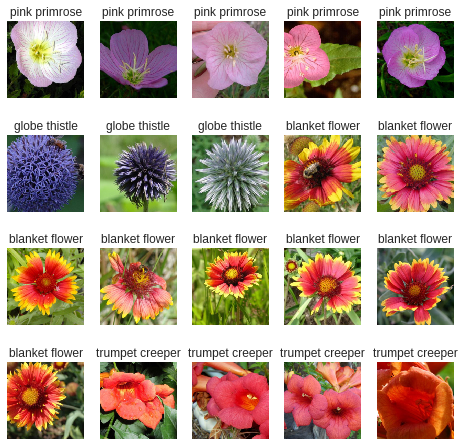

In [62]:
images, labels = iter(testloaders).next()

import matplotlib.pyplot as plt
#%matplotlib inline

# helper function to un-normalize and display an image
def imshow(img):
#    img = img/5 + 0.5  # unnormalize
    img[0] = img[0] * std[0] + mean[0]
    img[1] = img[1] * std[1] + mean[1]
    img[2] = img[2] * std[2] + mean[2]
    plt.imshow(np.transpose(img, (1, 2, 0)))

images = images.numpy() # convert images to numpy for display

# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(8, 8))
# display 20 images
for idx in np.arange(20):
    ax = fig.add_subplot(4, 20/4, idx+1, xticks=[], yticks=[])
    imshow(images[idx])
    ax.set_title(cat_to_name[image_dataset.classes[labels[idx]]])


##Build model

###VGG16

In [0]:
#vgg model 
modelvgg = torchvision.models.vgg16(pretrained=True)

In [0]:
from collections import OrderedDict

for param in modelvgg.parameters():
    param.requires_grad = False
    
vggclassifier = torch.nn.Sequential(OrderedDict([
                          ('fc1', torch.nn.Linear(25088, 4096)),
                          ('relu', torch.nn.ReLU()), 
                          ('dropout', torch.nn.Dropout(0.2)),
                          ('fc2', torch.nn.Linear(4096, 4096)),
                          ('relu', torch.nn.ReLU()), 
                          ('dropout', torch.nn.Dropout(0.2)),
                          ('fc3', torch.nn.Linear(4096, 102)),
                          ('output', torch.nn.LogSoftmax(dim=1))
                          ]))
modelvgg.classifier = vggclassifier

###densenet121

In [8]:
# Load pre-trained network
modeldensenet = torchvision.models.densenet121(pretrained=True)

/usr/local/lib/python3.6/dist-packages/torchvision/models/densenet.py:212: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.
  nn.init.kaiming_normal(m.weight.data)


In [0]:
from collections import OrderedDict

for param in modeldensenet.parameters():
    param.requires_grad = False

classifier = torch.nn.Sequential(OrderedDict([
                          ('fc1', torch.nn.Linear(1024, 500)),
                          ('relu', torch.nn.ReLU()), 
                          ('dropout', torch.nn.Dropout(0.2)),
                          ('fc2', torch.nn.Linear(500, 102)),
                          ('output', torch.nn.LogSoftmax(dim=1))
                          ]))
    
modeldensenet.classifier = classifier

###Densenet 161

In [9]:
# Load pre-trained network
modeldensenet2 = torchvision.models.densenet161(pretrained=True)

/usr/local/lib/python3.6/dist-packages/torchvision/models/densenet.py:212: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.
  nn.init.kaiming_normal(m.weight.data)


(classifier): Linear(in_features=2208, out_features=1000, bias=True)

In [0]:
from collections import OrderedDict

#for param in modeldensenet2.parameters():
#    param.requires_grad = False

classifier2 = torch.nn.Sequential(OrderedDict([
                          ('fc1', torch.nn.Linear(2208, 1024)),
                          ('relu', torch.nn.ReLU()), 
                          ('dropout', torch.nn.Dropout(0.2)),
                          ('fc2', torch.nn.Linear(1024, 102)),
                          ('output', torch.nn.LogSoftmax(dim=1))
                          ]))
    
modeldensenet2.classifier = classifier2

###Device

In [10]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

###Model

In [11]:
model = modeldensenet
model.to(device)

DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace)
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace)
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplac

###Criterion and optimizer

In [0]:
criterion = torch.nn.NLLLoss()
optimizer = torch.optim.Adam(model.classifier.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.5)

##Train

In [14]:
epochs = 5
steps = 0
running_loss = 0
max_accuracy = 0
print_every = 5
path = "drive/My Drive/Colab Notebooks/modelvdensenet161v2.pt"

for epoch in range(epochs):
#    scheduler.step()
    for inputs, labels in dataloaders:
        steps += 1
        # Move input and label tensors to the default device
        inputs, labels = inputs.to(device), labels.to(device)
        
        optimizer.zero_grad()
        
        logps = model.forward(inputs)
        loss = criterion(logps, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        
        if steps % print_every == 0:
            test_loss = 0
            accuracy = 0
            model.eval()
            with torch.no_grad():
                for inputs, labels in validloaders:
                    inputs, labels = inputs.to(device), labels.to(device)
                    logps = model.forward(inputs)
                    batch_loss = criterion(logps, labels)
                    
                    test_loss += batch_loss.item()
                    
                    # Calculate accuracy
                    ps = torch.exp(logps)
                    top_p, top_class = ps.topk(1, dim=1)
                    equals = top_class == labels.view(*top_class.shape)
                    accuracy += torch.mean(equals.type(torch.FloatTensor)).item()
                    
            print(f"Epoch {epoch+1}/{epochs}.. "
                  f"Train loss: {running_loss/print_every:.3f}.. "
                  f"Test loss: {test_loss/len(validloaders):.3f}.. "
                  f"Test accuracy: {accuracy/len(validloaders):.3f}")
            #save model
            if max_accuracy < accuracy/len(validloaders):
              max_accuracy = accuracy/len(validloaders)
              torch.save(model.state_dict(), path)             
            running_loss = 0
            model.train()

Epoch 1/5.. Train loss: 4.602.. Test loss: 4.360.. Test accuracy: 0.050
Epoch 1/5.. Train loss: 4.303.. Test loss: 4.243.. Test accuracy: 0.145
Epoch 1/5.. Train loss: 4.332.. Test loss: 4.153.. Test accuracy: 0.173
Epoch 1/5.. Train loss: 4.233.. Test loss: 4.043.. Test accuracy: 0.212
Epoch 1/5.. Train loss: 4.045.. Test loss: 3.898.. Test accuracy: 0.269
Epoch 1/5.. Train loss: 3.954.. Test loss: 3.742.. Test accuracy: 0.294
Epoch 1/5.. Train loss: 3.944.. Test loss: 3.609.. Test accuracy: 0.266
Epoch 1/5.. Train loss: 3.452.. Test loss: 3.471.. Test accuracy: 0.303
Epoch 1/5.. Train loss: 3.560.. Test loss: 3.327.. Test accuracy: 0.284
Epoch 1/5.. Train loss: 3.492.. Test loss: 3.128.. Test accuracy: 0.383
Epoch 1/5.. Train loss: 3.318.. Test loss: 3.007.. Test accuracy: 0.397
Epoch 1/5.. Train loss: 3.280.. Test loss: 2.842.. Test accuracy: 0.427
Epoch 1/5.. Train loss: 2.936.. Test loss: 2.739.. Test accuracy: 0.423
Epoch 1/5.. Train loss: 2.923.. Test loss: 2.571.. Test accuracy

In [0]:
max_accuracy

0.9624038476210374

##Save model
model is checked every 5 steps and saved if performance is better than in last checkpoint

In [0]:
# path = "drive/My Drive/Colab Notebooks/modelv2.pt"
# model.class_to_idx = image_dataset.class_to_idx
# torch.save(model.state_dict(), path)

##Load mdel

In [13]:
model = modeldensenet2
model.load_state_dict(torch.load('drive/My Drive/Colab Notebooks/modelvdensenet161.pt'), strict=False)
model.classifier = classifier2
model.to(device)
model.eval()

DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 96, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace)
        (conv1): Conv2d(96, 192, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(192, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace)
        (conv2): Conv2d(192, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(144, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inpla

In [0]:
from PIL import Image

labels = image_dataset.class_to_idx
inv_labels = {v: k for k, v in labels.items()}

def image_load(image_path, transforms):
  image = Image.open(image_path)
  image = transforms(image).float()
  image = image.unsqueeze(0)
  return image


def topk(model, image, k=3):
  with torch.no_grad():
    output = model.forward(image)
  top = torch.exp(output).topk(k)
  classes = top[1].numpy().squeeze()
  values = top[0].numpy().squeeze()
  for i in range(0, len(classes)):
    print('{} : {}%'.format(cat_to_name[inv_labels[classes[i]]], round(values[i]*100, 2)))


##Test

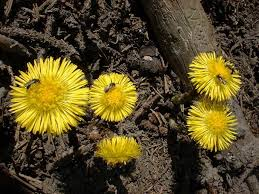

In [0]:
img_path = 'drive/My Drive/Colab Notebooks/Data/test6.jpg'
import IPython.display
IPython.display.Image(img_path)

In [0]:
image = image_load(img_path, test_transforms)
topk(model.to('cpu'), image, 3)

colt's foot : 99.79%
common dandelion : 0.09%
purple coneflower : 0.05%


###Test accuracy for test dataset

In [0]:
test_loss = 0
accuracy = 0
criterion = torch.nn.NLLLoss()
model.to(device)
with torch.no_grad():
  for inputs, labels in testloaders:
    inputs, labels = inputs.to(device), labels.to(device)
    logps = model.forward(inputs)
    batch_loss = criterion(logps, labels)
                    
    test_loss += batch_loss.item()
                    
    # Calculate accuracy
    ps = torch.exp(logps)
    top_p, top_class = ps.topk(1, dim=1)
    equals = top_class == labels.view(*top_class.shape)
    accuracy += torch.mean(equals.type(torch.FloatTensor)).item()
                    
print(f"Test loss: {test_loss/len(testloaders):.3f}.. "
      f"Test accuracy: {accuracy/len(testloaders):.3f}")

Test loss: 0.114.. Test accuracy: 0.973
